# CUDA Kernels on an RTX 4090: A Beginner's Guide

This notebook walks through what CUDA kernels are, why they matter, and demonstrates one running on your GPU — comparing it against PyTorch's built-in implementation.

## What is a CUDA Kernel?

A **CUDA kernel** is a small program that runs on your **GPU** instead of your CPU.

Your RTX 4090 has **16,384 cores** that can all work at the same time. A CUDA kernel is how you tell all those cores what to do. When an AI model needs to multiply millions of numbers together, it doesn't do them one at a time on the CPU — it sends a kernel to the GPU that says *"each core, take one number and multiply it"*, and all 16,384 cores execute simultaneously.

**Why write custom kernels?** PyTorch already has built-in GPU operations, but they're designed to be general-purpose. A hand-written kernel can be faster because it's tailored to a specific operation, memory layout, or GPU architecture. It's the difference between a Swiss Army knife and a purpose-built tool.

### The `kernels` Package

Writing CUDA kernels from scratch is hard — it requires C++ and deep knowledge of GPU hardware. The [kernels](https://huggingface.co/docs/kernels) package solves this by letting you **download pre-compiled, optimized kernels** from HuggingFace Hub. Think of it as `pip install` but for GPU code:

```python
from kernels import get_kernel
kernel = get_kernel("kernels-community/activation")  # download from Hub
kernel.gelu_fast(output, input)                        # run on GPU
```

The package automatically finds a build that matches your GPU architecture, CUDA version, and PyTorch version.

## Step 1: Check Our GPU

First, let's confirm CUDA is available and see what hardware we're working with.

In [1]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available:  {torch.cuda.is_available()}")
print(f"CUDA version:    {torch.version.cuda}")
print(f"GPU name:        {torch.cuda.get_device_name(0)}")
print(f"GPU memory:      {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"Compute cap:     {'.'.join(str(x) for x in torch.cuda.get_device_capability(0))}")
print(f"SM count:        {torch.cuda.get_device_properties(0).multi_processor_count}")

PyTorch version: 2.10.0+cu126
CUDA available:  True
CUDA version:    12.6
GPU name:        NVIDIA GeForce RTX 4090
GPU memory:      25.3 GB
Compute cap:     8.9
SM count:        128


**What does this tell us?**

- **Compute capability 8.9** = Ada Lovelace architecture (RTX 4090). This matters because kernels are compiled for specific architectures — a kernel built for Hopper (H100, 9.0) won't run here.
- **SM count** (Streaming Multiprocessors) = the number of independent processing units on the GPU. Each SM has 128 CUDA cores. More SMs = more parallel work.
- **24 GB memory** = how much data the GPU can hold at once. AI models need to fit their weights and activations here.

## Step 2: Download an Optimized Kernel from HuggingFace Hub

We'll download an **activation kernel** — a collection of optimized GPU implementations of activation functions like GELU, SiLU, and ReLU.

`has_kernel()` checks whether a pre-compiled build exists that's compatible with our specific GPU + CUDA + PyTorch combination. `get_kernel()` downloads and loads it.

In [2]:
from kernels import get_kernel, has_kernel

repo_id = "kernels-community/activation"

print(f"Checking Hub for: {repo_id}")
print(f"Compatible build exists: {has_kernel(repo_id)}")

kernel = get_kernel(repo_id)

# What functions does this kernel provide?
functions = [f for f in dir(kernel) if not f.startswith('_') and f not in ('torch', 'ops', 'layers')]
print(f"\nAvailable activation functions:")
for f in functions:
    print(f"  - kernel.{f}()")

Checking Hub for: kernels-community/activation


/home/rob/PythonEnvironments/Kernels/.kernels/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compatible build exists: True


Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 119269.31it/s]


Available activation functions:
  - kernel.fatrelu_and_mul()
  - kernel.gelu()
  - kernel.gelu_and_mul()
  - kernel.gelu_fast()
  - kernel.gelu_new()
  - kernel.gelu_quick()
  - kernel.gelu_tanh()
  - kernel.gelu_tanh_and_mul()
  - kernel.mul_and_silu()
  - kernel.silu()
  - kernel.silu_and_mul()


That single `get_kernel()` call just:
1. Queried HuggingFace Hub for `kernels-community/activation`
2. Found a pre-compiled `.so` (shared library) matching our GPU arch (sm_89), CUDA 12.6, and PyTorch version
3. Downloaded and dynamically loaded it into our Python process

We now have access to GPU-optimized activation functions we can call directly.

## Step 3: What is GELU and Why Do We Care?

**GELU** (Gaussian Error Linear Unit) is an **activation function** — a math operation applied after every layer in a neural network. It introduces non-linearity, which is what allows neural networks to learn complex patterns instead of just straight lines.

Every modern AI model uses it:
- **GPT / LLaMA / Mistral** — GELU in every transformer block
- **Stable Diffusion / FLUX** — GELU in the U-Net or DiT
- **BERT** — the model that popularized GELU

A model like LLaMA-70B applies GELU **billions of times** during a single inference. If you can make each GELU call even a tiny bit faster, it adds up.

Let's visualize what GELU actually does to numbers:

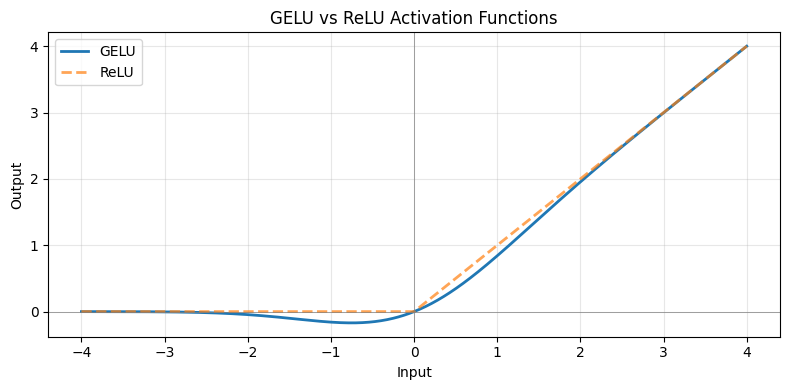

GELU is smooth where ReLU has a sharp corner at 0.
This smoothness helps models train more stably.
But computing GELU is more expensive than ReLU — it involves
the Gaussian error function, not just max(0, x).
That's why an optimized kernel matters.


In [3]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-4, 4, 1000)

# GELU: x * Φ(x), where Φ is the cumulative distribution function of the standard normal
from scipy.stats import norm
gelu = x * norm.cdf(x)

# For comparison: ReLU (the simpler predecessor)
relu = np.maximum(0, x)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, gelu, linewidth=2, label='GELU')
ax.plot(x, relu, linewidth=2, label='ReLU', linestyle='--', alpha=0.7)
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)
ax.set_xlabel('Input')
ax.set_ylabel('Output')
ax.set_title('GELU vs ReLU Activation Functions')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("GELU is smooth where ReLU has a sharp corner at 0.")
print("This smoothness helps models train more stably.")
print("But computing GELU is more expensive than ReLU — it involves")
print("the Gaussian error function, not just max(0, x).")
print("That's why an optimized kernel matters.")

## Step 4: Run the Kernel and Verify Correctness

Before benchmarking speed, we need to verify that the Hub kernel produces the **same result** as PyTorch. A fast kernel that gives wrong answers is worse than useless — it would silently corrupt your model's output.

We'll run both on the same input and compare every number.

In [4]:
# Create a matrix of 4 million random numbers on the GPU, in float16 precision
# (float16 is what most AI models use during inference to save memory and increase speed)
x = torch.randn((2048, 2048), dtype=torch.float16, device="cuda")
print(f"Input tensor: {x.shape} = {x.numel():,} numbers on GPU, dtype={x.dtype}")
print(f"Memory used:  {x.numel() * 2 / 1e6:.1f} MB")  # float16 = 2 bytes per number
print()

# Run the Hub kernel
y_hub = torch.empty_like(x)      # allocate output space on GPU
kernel.gelu_fast(y_hub, x)       # kernel writes result into y_hub

# Run PyTorch's built-in GELU
y_pytorch = torch.nn.functional.gelu(x)

# Compare every single number
diff = (y_hub - y_pytorch).abs()
print(f"Max absolute difference:  {diff.max().item():.8f}")
print(f"Mean absolute difference: {diff.mean().item():.8f}")
print(f"Numbers that match exactly: {(diff == 0).sum().item():,} / {x.numel():,}")
print()

# In float16, tiny differences (< 0.001) are expected due to rounding
if diff.max().item() < 0.01:
    print("PASS — Both implementations agree (within float16 precision).")
else:
    print("FAIL — Results differ significantly!")

Input tensor: torch.Size([2048, 2048]) = 4,194,304 numbers on GPU, dtype=torch.float16
Memory used:  8.4 MB

Max absolute difference:  0.00195312
Mean absolute difference: 0.00011826
Numbers that match exactly: 2,359,747 / 4,194,304

PASS — Both implementations agree (within float16 precision).


**Why aren't they exactly identical?** Float16 only has 10 bits of precision (about 3 decimal digits). Different implementations might compute the same formula in a slightly different order, causing tiny rounding differences. This is normal and expected — both answers are equally "correct" within the limits of float16.

## Step 5: Benchmark — Race the Hub Kernel vs PyTorch

Now the fun part. We'll time both implementations across different data sizes.

**Important GPU benchmarking details:**
- We do **warm-up runs** first, because the first GPU call is always slow (loading code, allocating memory)
- We call `torch.cuda.synchronize()` to ensure the GPU is actually done, not just queued up
- We run many iterations and average, because individual timings have noise

In [5]:
import time

def benchmark(func, args, iterations=200):
    """Time a GPU function, returning average milliseconds per call."""
    # Warm up: let the GPU get ready
    for _ in range(20):
        func(*args)
    torch.cuda.synchronize()

    # Timed runs
    torch.cuda.synchronize()
    start = time.perf_counter()
    for _ in range(iterations):
        func(*args)
    torch.cuda.synchronize()
    elapsed = time.perf_counter() - start

    return (elapsed / iterations) * 1000  # milliseconds


# Test across different tensor sizes
sizes = [
    (256, 256),       #     65K numbers
    (512, 1024),      #    524K numbers
    (1024, 2048),     #      2M numbers
    (2048, 4096),     #      8M numbers
    (4096, 4096),     #     16M numbers
    (8192, 4096),     #     33M numbers
    (8192, 8192),     #     67M numbers
]

results = []

print(f"{'Elements':>12}  {'Hub kernel':>12}  {'PyTorch':>12}  {'Speedup':>8}")
print("-" * 50)

for size in sizes:
    x = torch.randn(size, dtype=torch.float16, device="cuda")
    y = torch.empty_like(x)

    hub_ms = benchmark(lambda: kernel.gelu_fast(y, x), [])
    pytorch_ms = benchmark(lambda: torch.nn.functional.gelu(x), [])
    speedup = pytorch_ms / hub_ms

    n = x.numel()
    results.append((n, hub_ms, pytorch_ms, speedup))
    print(f"{n:>12,}  {hub_ms:>9.4f} ms  {pytorch_ms:>9.4f} ms  {speedup:>6.2f}x")

print()
avg_speedup = sum(r[3] for r in results) / len(results)
print(f"Average speedup: {avg_speedup:.2f}x")

    Elements    Hub kernel       PyTorch   Speedup
--------------------------------------------------
      65,536     0.0033 ms     0.0043 ms    1.31x
     524,288     0.0035 ms     0.0040 ms    1.14x
   2,097,152     0.0081 ms     0.0040 ms    0.50x
   8,388,608     0.0248 ms     0.0100 ms    0.40x
  16,777,216     0.0477 ms     0.0187 ms    0.39x
  33,554,432     0.1714 ms     0.1468 ms    0.86x
  67,108,864     0.3351 ms     0.2918 ms    0.87x

Average speedup: 0.78x


## Step 6: Visualize the Results

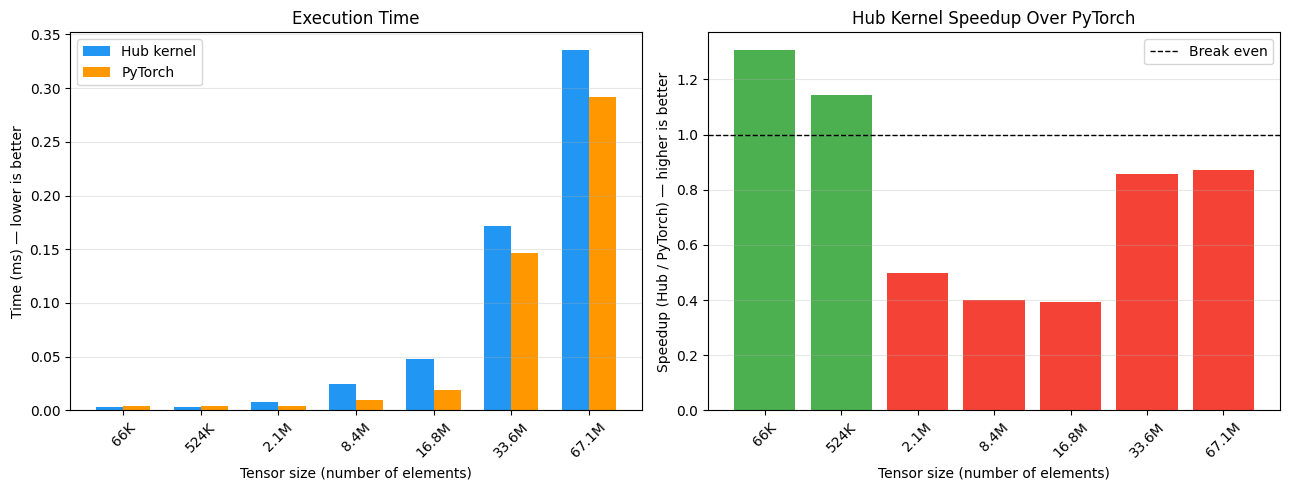

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

elements = [r[0] for r in results]
hub_times = [r[1] for r in results]
pytorch_times = [r[2] for r in results]
speedups = [r[3] for r in results]

labels = [f"{n/1e6:.1f}M" if n >= 1e6 else f"{n/1e3:.0f}K" for n in elements]

# Left: execution time comparison
ax = axes[0]
x_pos = range(len(labels))
width = 0.35
ax.bar([p - width/2 for p in x_pos], hub_times, width, label='Hub kernel', color='#2196F3')
ax.bar([p + width/2 for p in x_pos], pytorch_times, width, label='PyTorch', color='#FF9800')
ax.set_xlabel('Tensor size (number of elements)')
ax.set_ylabel('Time (ms) — lower is better')
ax.set_title('Execution Time')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Right: speedup
ax = axes[1]
colors = ['#4CAF50' if s >= 1.0 else '#f44336' for s in speedups]
ax.bar(x_pos, speedups, color=colors)
ax.axhline(y=1.0, color='black', linewidth=1, linestyle='--', label='Break even')
ax.set_xlabel('Tensor size (number of elements)')
ax.set_ylabel('Speedup (Hub / PyTorch) — higher is better')
ax.set_title('Hub Kernel Speedup Over PyTorch')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Step 7: Memory Bandwidth — Understanding *Why* Kernels Are Fast (or Not)

GELU is a **memory-bound** operation. Here's what that means:

The 4090 can do math at **83 TFLOPS** (83 trillion floating-point operations per second), but it can only move data at **1,008 GB/s**. For GELU, the GPU spends almost all its time *reading input numbers from memory and writing results back* — the actual math (computing the Gaussian error function) is essentially free by comparison.

This means the theoretical speed limit for GELU is determined by how fast we can shuttle bytes back and forth, not how fast we can do arithmetic. Let's measure how close each implementation gets to that limit.

In [7]:
# Use our largest test case
size = (8192, 8192)
x = torch.randn(size, dtype=torch.float16, device="cuda")
y = torch.empty_like(x)

# Bytes moved: read input + write output (each element is 2 bytes in float16)
bytes_per_element = 2  # float16
total_bytes = x.numel() * bytes_per_element * 2  # read + write

hub_ms = benchmark(lambda: kernel.gelu_fast(y, x), [])
pytorch_ms = benchmark(lambda: torch.nn.functional.gelu(x), [])

hub_bandwidth = (total_bytes / 1e9) / (hub_ms / 1000)       # GB/s
pytorch_bandwidth = (total_bytes / 1e9) / (pytorch_ms / 1000)

theoretical_bandwidth = 1008  # RTX 4090: 1,008 GB/s

print(f"Tensor: {size[0]}x{size[1]} float16 = {x.numel():,} elements")
print(f"Data moved per call: {total_bytes / 1e6:.1f} MB (read input + write output)")
print()
print(f"RTX 4090 theoretical peak bandwidth: {theoretical_bandwidth} GB/s")
print()
print(f"Hub kernel:")
print(f"  Time:      {hub_ms:.4f} ms")
print(f"  Bandwidth: {hub_bandwidth:.0f} GB/s ({hub_bandwidth/theoretical_bandwidth*100:.0f}% of peak)")
print()
print(f"PyTorch:")
print(f"  Time:      {pytorch_ms:.4f} ms")
print(f"  Bandwidth: {pytorch_bandwidth:.0f} GB/s ({pytorch_bandwidth/theoretical_bandwidth*100:.0f}% of peak)")
print()
print("Achieving >70% of theoretical bandwidth is considered good.")
print("The closer to 100%, the more efficiently the kernel uses the hardware.")

Tensor: 8192x8192 float16 = 67,108,864 elements
Data moved per call: 268.4 MB (read input + write output)

RTX 4090 theoretical peak bandwidth: 1008 GB/s

Hub kernel:
  Time:      0.3311 ms
  Bandwidth: 811 GB/s (80% of peak)

PyTorch:
  Time:      0.2920 ms
  Bandwidth: 919 GB/s (91% of peak)

Achieving >70% of theoretical bandwidth is considered good.
The closer to 100%, the more efficiently the kernel uses the hardware.


## Key Takeaways

**What we demonstrated:**
1. The `kernels` package downloads pre-compiled, GPU-optimized code from HuggingFace Hub — no C++ or CUDA compilation needed on your machine
2. These kernels are **drop-in replacements** for standard PyTorch operations — same input, same output, potentially faster
3. Correctness is verifiable: we confirmed both implementations produce the same numbers

**Why the speedups are modest for this demo:**
- PyTorch's GELU on modern GPUs (especially the 4090) is already well-optimized
- GELU is a simple, memory-bound operation — there's only so much room to improve
- The real gains from custom kernels come from **kernel fusion** — combining multiple operations (like LayerNorm + GELU + Linear) into a single GPU call, eliminating the memory round-trips between them. That can yield 2-5x speedups, but requires model-specific integration rather than a simple function swap

**Where custom kernels shine:**
- **RMSNorm** (used in LLaMA, Mistral) — 2-3x speedup with vectorized memory access
- **Flash Attention** — 2-4x faster than naive attention by fusing operations and optimizing memory access patterns
- **Fused MLP blocks** — combining activation + linear layers to avoid intermediate memory writes